<a href="https://colab.research.google.com/github/claudio1975/Medium-blog/blob/master/Zero_Shot_Text_Classification/zero_shot_text_classification_hugging_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What is zero-shot text classification?

Text classification is a task of natural language processing where the model predicts the classes of pieces of text in a document. The traditional approach requires a huge amount of labelled data to train the model and falls down when there is not enough labelled data in the training process. Solving text classification task with zero-shot learning we obtain the zero-shot text classification which has the task of classifying text documents without having seen any labelled text class before during the training process, and one way to do this is by using natural language inference (NLI) proposed by [Yin et al (2019)](https://arxiv.org/pdf/1909.00161.pdf). You can find implementations of zero-shot classification in the transformer models, and in the hugging face hub, where these models are available.

### What is Hugging-Face

Hugging Face is a platform built in order to democratize artificial intelligence, where data scientists and machine learning engineers can collaborate on models, and datasets, with the opportunity to deploy applications.

### Goal of the analysis

The goal of the job is to explore the performances of zero-shot classification models from Hugging-Face platform:

-[cross-encoder/nli-distilroberta-base](https://huggingface.co/cross-encoder/nli-distilroberta-base)

-[MoritzLaurer/deberta-v3-base-zeroshot-v1](https://huggingface.co/MoritzLaurer/deberta-v3-base-zeroshot-v1)

-[AyoubChLin/DistilBERT_ZeroShot](https://huggingface.co/AyoubChLin/DistilBERT_ZeroShot)

-[facebook/bart-large-mnli](https://huggingface.co/facebook/bart-large-mnli)


for the Zero-Shot Text Classification task using two data sets.

The first one is about sentiment analysis on a financial data set with 3 polarities: positive, neutral and negative.

The second one is about multi-class text classification on CNN articles data set with 6 labels: business, entertainment, health, news, politics and sport.

### Upload libraries and data sets

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.9 MB/s eta 0:00:00


In [ ]:
# upload the used libraries
import numpy as np
import pandas as pd
from transformers import pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import re
import os
import time
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving financial_data.csv to financial_data.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CNN_Articles.csv.zip to CNN_Articles.csv.zip


In [ ]:
# upload data sets
df_1=pd.read_csv("financial_data.csv")
df_2=pd.read_csv("CNN_Articles.csv.zip")

### Have a peek of first the data set

In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [ ]:
df_1.shape

(5842, 2)

In [ ]:
df_1.columns

Index(['Sentence', 'Sentiment'], dtype='object')

In [ ]:
df_1.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


### Target variable analysis

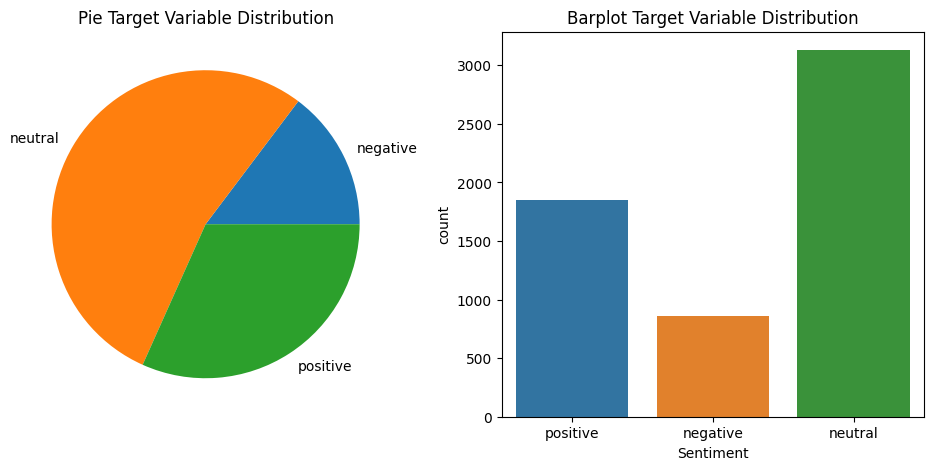

In [ ]:
# Plot the target variable
# Create a figure with two subplots (axes) side by side
fig, axes=plt.subplots(ncols=2, figsize=(12,5))
# Create a pie chart of the sentiment counts on the first subplot
pieplot = df_1.groupby('Sentiment').count()['Sentence'].plot(kind='pie',ax=axes[0]).set_title("Pie Target Variable Distribution")
# Create a bar chart of the sentiment counts on the second subplot
barplot=sns.countplot(x='Sentiment', data=df_1, ax=axes[1]).set_title("Barplot Target Variable Distribution")
# Remove the y-axis label from the first subplot
axes[0].set_ylabel('')
# Display the figure
plt.show()

In [ ]:
# distribution variable "Sentiment" as target variable
# Create a table that counts the number of sentences in each sentiment category
count=pd.crosstab(index=df_1['Sentiment'], columns='count')
# Create a table that calculates the percentage of sentences in each sentiment category
percentage=pd.crosstab(index=df_1['Sentiment'],
                       columns='frequency')/pd.crosstab(index=df_1['Sentiment'], columns='frequency').sum()
# Concatenate the two tables and display the result
pd.concat([count,percentage], axis=1)

col_0,count,frequency
Sentiment,,
negative,860,0.147210
neutral,3130,0.535775
positive,1852,0.317015


### Zero-Shot Text Classification for the first data set

In [ ]:
# retrieve a sample from the data set
# set the random seed for reproducibility
np.random.seed(0)
df_1_ = df_1.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(frac=0.1)) # stratified sampling

In [ ]:
# select text column to fit zero-shot classification
X=df_1_.iloc[:,0]

In [ ]:
# transformer pipeline
classifier_1 = pipeline("zero-shot-classification",
                      model="cross-encoder/nli-distilroberta-base")

In [ ]:
start= time.time()
sequence_to_classify = X.iloc[:]
candidate_labels = ['negative', 'neutral', 'positive']
sent_list_distilroberta = []
for text in sequence_to_classify:
    label = classifier_1(text, candidate_labels)
    sent_list_distilroberta.append(label)
end=time.time()
print ({end - start})

{137.2646644115448}


In [ ]:
predicted_labels_distilroberta = pd.DataFrame([sent_list_distilroberta['labels'][0] for sent_list_distilroberta in sent_list_distilroberta], columns=['predicted_labels_distilroberta'])

In [ ]:
# transformer pipeline
classifier_2 = pipeline("zero-shot-classification",
                      model="MoritzLaurer/deberta-v3-base-zeroshot-v1")

In [ ]:
start= time.time()
sequence_to_classify = X.iloc[:]
candidate_labels = ['negative', 'neutral', 'positive']
sent_list_deberta = []
for text in sequence_to_classify:
    label = classifier_2(text, candidate_labels)
    sent_list_deberta.append(label)
end=time.time()
print ({end - start})

{683.7700042724609}


In [ ]:
predicted_labels_deberta = pd.DataFrame([sent_list_deberta['labels'][0] for sent_list_deberta in sent_list_deberta], columns=['predicted_labels_deberta'])

In [ ]:
# transformer pipeline
classifier_3 = pipeline("zero-shot-classification",
                      model="AyoubChLin/DistilBERT_ZeroShot")

In [ ]:
start= time.time()
sequence_to_classify = X.iloc[:]
candidate_labels = ['negative', 'neutral', 'positive']
sent_list_distilbert = []
for text in sequence_to_classify:
    label = classifier_3(text, candidate_labels)
    sent_list_distilbert.append(label)
end=time.time()
print ({end - start})

{131.82768535614014}


In [ ]:
predicted_labels_distilbert = pd.DataFrame([sent_list_distilbert['labels'][0] for sent_list_distilbert in sent_list_distilbert], columns=['predicted_labels_distilbert'])

In [ ]:
# transformer pipeline
classifier_4 = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [ ]:
start= time.time()
sequence_to_classify = X.iloc[:]
candidate_labels = ['negative', 'neutral', 'positive']
sent_list_bart = []
for text in sequence_to_classify:
    label = classifier_4(text, candidate_labels)
    sent_list_bart.append(label)
end=time.time()
print ({end - start})

{1102.007951259613}


In [ ]:
predicted_labels_bart = pd.DataFrame([sent_list_bart['labels'][0] for sent_list_bart in sent_list_bart], columns=['predicted_labels_bart'])

In [ ]:
# build a new data set with predictions
df_1_p = pd.concat([df_1_,predicted_labels_distilroberta.set_index(df_1_.index), predicted_labels_deberta.set_index(df_1_.index),
                    predicted_labels_distilbert.set_index(df_1_.index),predicted_labels_bart.set_index(df_1_.index)],axis=1)

In [ ]:
df_1_p.head()

,Sentence,Sentiment,predicted_labels_distilroberta,predicted_labels_deberta,predicted_labels_distilbert,predicted_labels_bart
1068,"Fastenal misses by $0.01, misses on revenue $F...",negative,negative,negative,positive,negative
1428,BHP Billiton drags FTSE lower after slashing d...,negative,negative,negative,positive,negative
1903,FastJet slams EasyJet founder Stelios for goin...,negative,negative,negative,positive,negative
1808,"Glencore Cuts 2015 Budget, Plans To Divest Fro...",negative,negative,negative,positive,negative
3673,"The Baltimore Police and Fire Pension , which ...",negative,negative,negative,positive,negative


### Evaluation from the first data set

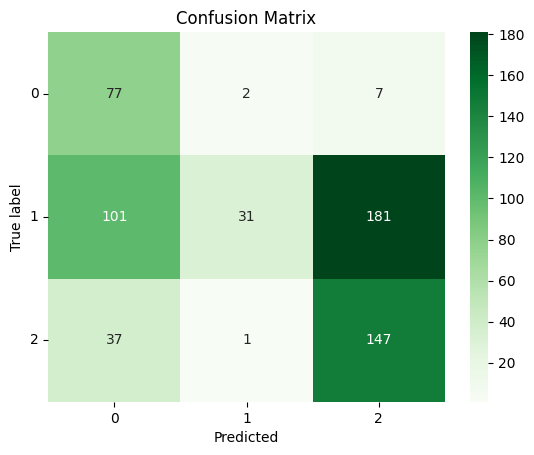

In [ ]:
# confusion matrix
cm= confusion_matrix(df_1_p.Sentiment,df_1_p.predicted_labels_distilroberta)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Greens, cbar=True)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

In [ ]:
# F1 score
distilroberta_f1_score=f1_score(df_1_p.Sentiment,df_1_p.predicted_labels_distilroberta, average='micro')
distilroberta_f1_score

0.4366438356164384

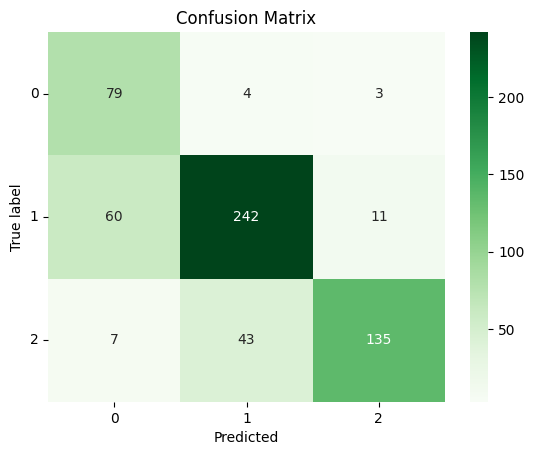

In [ ]:
# confusion matrix
cm= confusion_matrix(df_1_p.Sentiment,df_1_p.predicted_labels_deberta)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Greens, cbar=True)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

In [ ]:
# F1 score
deberta_f1_score=f1_score(df_1_p.Sentiment,df_1_p.predicted_labels_deberta, average='micro')
deberta_f1_score

0.7808219178082192

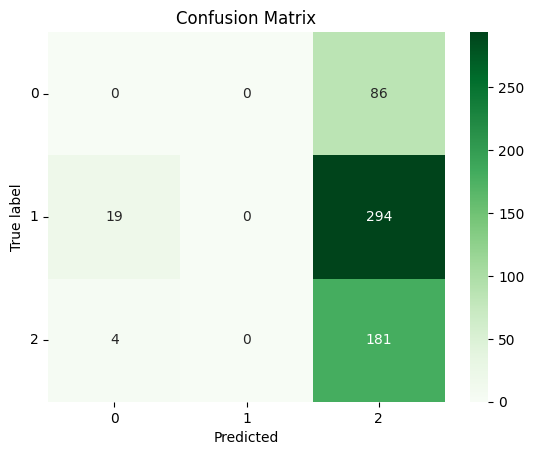

In [ ]:
# confusion matrix
cm= confusion_matrix(df_1_p.Sentiment,df_1_p.predicted_labels_distilbert)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Greens, cbar=True)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

In [ ]:
# F1 score
distilbert_f1_score=f1_score(df_1_p.Sentiment,df_1_p.predicted_labels_distilbert, average='micro')
distilbert_f1_score

0.3099315068493151

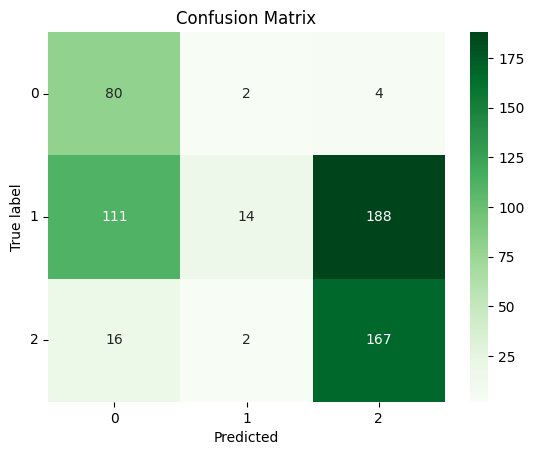

In [ ]:
# confusion matrix
cm= confusion_matrix(df_1_p.Sentiment,df_1_p.predicted_labels_bart)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Greens, cbar=True)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

In [ ]:
# F1 score
bart_f1_score=f1_score(df_1_p.Sentiment,df_1_p.predicted_labels_bart, average='micro')
bart_f1_score

0.4469178082191781

In [ ]:
score_1 = {
        'metrics':'f1_score',
        'distillberta': distilroberta_f1_score,
        'deberta': deberta_f1_score,
        'distilbert': distilbert_f1_score,
        'bart': bart_f1_score
    }
score_1
score_data_1 = pd.DataFrame(score_1, index=[0])
score_data_1

,metrics,distillberta,deberta,distilbert,bart
0,f1_score,0.436644,0.780822,0.309932,0.446918


### Have a peek of second the data set

In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9308 entries, 0 to 9307
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            9308 non-null   int64 
 1   author                9308 non-null   object
 2   date_published        9308 non-null   object
 3   part_of               9308 non-null   object
 4   article_section       9308 non-null   object
 5   url                   9308 non-null   object
 6   headline              9308 non-null   object
 7   description           9308 non-null   object
 8   keywords              9308 non-null   object
 9   alternative_headline  9308 non-null   object
 10  text                  9308 non-null   object
dtypes: int64(1), object(10)
memory usage: 800.0+ KB


In [ ]:
df_2.shape

(9308, 11)

In [ ]:
df_2.columns

Index(['Unnamed: 0', 'author', 'date_published', 'part_of', 'article_section',
       'url', 'headline', 'description', 'keywords', 'alternative_headline',
       'text'],
      dtype='object')

In [ ]:
df_2.head()

,Unnamed: 0,author,date_published,part_of,article_section,url,headline,description,keywords,alternative_headline,text
0,0,"Jacopo Prisco, CNN",2021-07-15T02:46:59Z,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,1,"Jacopo Prisco, CNN",2021-07-15T02:46:59Z,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
2,2,"Stephanie Bailey, CNN",2021-05-12T07:52:09Z,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
3,3,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16T02:51:30Z,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
4,4,"Paul R. La Monica, CNN Business",2022-03-15T09:57:36Z,business,investing,https://www.cnn.com/2022/03/15/investing/brics...,Russia is no longer an option for investors. T...,"For many years, the world's most popular emerg...","investing, Russia is no longer an option for i...",Russia is no longer an option for investors. T...,"New York (CNN Business)For many years, the wor..."


### Target variable analysis

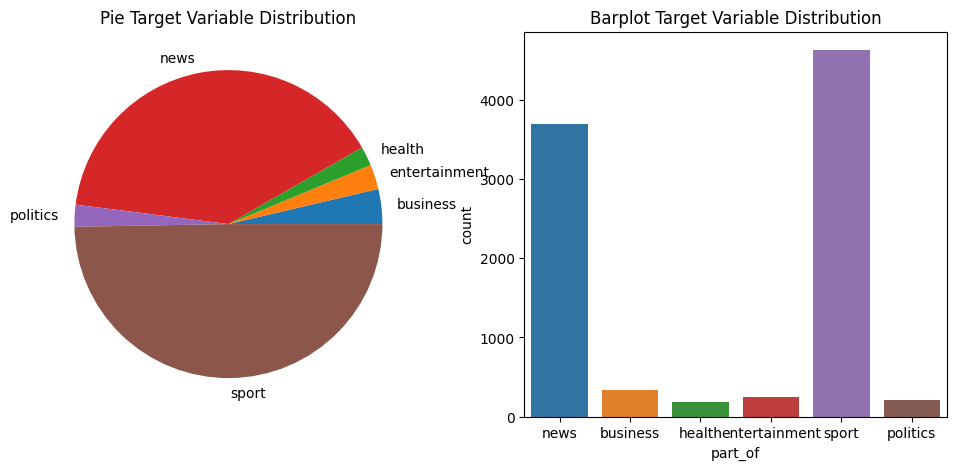

In [ ]:
# Plot the target variable
# Create a figure with two subplots (axes) side by side
fig, axes=plt.subplots(ncols=2, figsize=(12,5))
# Create a pie chart of the sentiment counts on the first subplot
pieplot=df_2.groupby('part_of').count()['Unnamed: 0'].plot(kind='pie',ax=axes[0]).set_title('Pie Target Variable Distribution')
# Create a bar chart of the sentiment counts on the second subplot
barplot=sns.countplot(x='part_of', data=df_2, ax=axes[1]).set_title("Barplot Target Variable Distribution")
# Remove the y-axis label from the first subplot
axes[0].set_ylabel('')
# Display the figure
plt.show()

In [ ]:
# distribution variable "part_of" as target variable
# Create a table that counts the number of sentences in each sentiment category
count=pd.crosstab(index=df_2['part_of'], columns='count')
# Create a table that calculates the percentage of sentences in each sentiment category
percentage=pd.crosstab(index=df_2['part_of'],
                       columns='frequency')/pd.crosstab(index=df_2['part_of'], columns='frequency').sum()
# Concatenate the two tables and display the result
pd.concat([count,percentage], axis=1)

col_0,count,frequency
part_of,,
business,341,0.036635
entertainment,242,0.025999
health,188,0.020198
news,3695,0.396970
politics,214,0.022991
sport,4628,0.497207


### Zero-Shot Text Classification for the second data set

In [ ]:
# retrieve a sample from the data set
# set the random seed for reproducibility
np.random.seed(0)
df_2_ = df_2.groupby('part_of', group_keys=False).apply(lambda x: x.sample(frac=0.1)) # stratified sampling

In [ ]:
# min text cleaning function
def clean_text(text):
    # Remove Unicode Characters
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", '',text)
    return text

In [ ]:
# text cleaning on "Description" variable
i=7
df_cleaned = pd.DataFrame(df_2_.apply(lambda x: clean_text(x.iloc[i]), axis=1), columns = ['description_cleaned'])
df_2__=pd.concat([df_2_,df_cleaned],axis=1)

In [ ]:
# select text column to fit zero-shot classification
X_=df_2__.iloc[:,11]

In [ ]:
start= time.time()
sequence_to_classify = X_.iloc[:]
candidate_labels = ["business","entertainment","health","news","politics","sport"]
sent_list_distilroberta_ = []
for text in sequence_to_classify:
    label = classifier_1(text, candidate_labels)
    sent_list_distilroberta_.append(label)
end=time.time()
print ({end - start})

{458.84349942207336}


In [ ]:
predicted_labels_distilroberta_ = pd.DataFrame([sent_list_distilroberta_['labels'][0] for sent_list_distilroberta_ in sent_list_distilroberta_], columns=['predicted_labels_distilroberta'])

In [ ]:
start= time.time()
sequence_to_classify = X_.iloc[:]
candidate_labels = ["business","entertainment","health","news","politics","sport"]
sent_list_deberta_ = []
for text in sequence_to_classify:
    label = classifier_2(text, candidate_labels)
    sent_list_deberta_.append(label)
end=time.time()
print ({end - start})

{2234.486342906952}


In [ ]:
predicted_labels_deberta_ = pd.DataFrame([sent_list_deberta_['labels'][0] for sent_list_deberta_ in sent_list_deberta_], columns=['predicted_labels_deberta'])

In [ ]:
start= time.time()
sequence_to_classify = X_.iloc[:]
candidate_labels = ["business","entertainment","health","news","politics","sport"]
sent_list_distilbert_ = []
for text in sequence_to_classify:
    label = classifier_3(text, candidate_labels)
    sent_list_distilbert_.append(label)
end=time.time()
print ({end - start})

{455.1169548034668}


In [ ]:
predicted_labels_distilbert_ = pd.DataFrame([sent_list_distilbert_['labels'][0] for sent_list_distilbert_ in sent_list_distilbert_], columns=['predicted_labels_distilbert'])

In [ ]:
start= time.time()
sequence_to_classify = X_.iloc[:]
candidate_labels = ["business","entertainment","health","news","politics","sport"]
sent_list_bart_ = []
for text in sequence_to_classify:
    label = classifier_4(text, candidate_labels)
    sent_list_bart_.append(label)
end=time.time()
print ({end - start})

{3966.0295634269714}


In [ ]:
predicted_labels_bart_ = pd.DataFrame([sent_list_bart_['labels'][0] for sent_list_bart_ in sent_list_bart_], columns=['predicted_labels_bart'])

In [ ]:
# build a new data set with predictions
df_2_p = pd.concat([df_2__,predicted_labels_distilroberta_.set_index(df_2__.index), predicted_labels_deberta_.set_index(df_2__.index),
                    predicted_labels_distilbert_.set_index(df_2__.index),predicted_labels_bart_.set_index(df_2__.index)],axis=1)

In [ ]:
df_2_p.head()

,Unnamed: 0,author,date_published,part_of,article_section,url,headline,description,keywords,alternative_headline,text,description_cleaned,predicted_labels_distilroberta,predicted_labels_deberta,predicted_labels_distilbert,predicted_labels_bart
284,284,"Anna Cooban, CNN Business",2022-03-15T12:13:39Z,business,business,https://www.cnn.com/2022/03/15/business/britai...,Britain's cost of living crisis is pushing mil...,Nazmin Begum has a problem: she's having to pa...,"business, Britain's cost of living crisis is p...",Britain's cost of living crisis is pushing mil...,London (CNN Business)Nazmin Begum has a proble...,Nazmin Begum has a problem shes having to pay ...,news,news,news,news
311,311,"Milly Chan, CNN Business",2021-10-27T01:37:49Z,business,tech,https://www.cnn.com/2021/10/26/tech/seatrec-be...,"Electric robots are mapping the seafloor, Eart...",Seatrec and Bedrock Ocean Exploration are two ...,"tech, Electric robots are mapping the seafloor...","Electric robots are mapping the seafloor, Eart...","(CNN Business)For centuries, humans have expl...",Seatrec and Bedrock Ocean Exploration are two ...,news,business,news,business
266,266,"Paul R. La Monica, CNN Business",2022-03-15T09:57:36Z,business,investing,https://www.cnn.com/2022/03/15/investing/brics...,Russia is no longer an option for investors. T...,"For many years, the world's most popular emerg...","investing, Russia is no longer an option for i...",Russia is no longer an option for investors. T...,"New York (CNN Business)For many years, the wor...",For many years the worlds most popular emergin...,news,business,news,business
19,19,CNN Business staff,2022-03-02T09:56:19Z,business,business,https://www.cnn.com/2022/03/02/business/compan...,Companies pulling back from Russia over the wa...,Dozens of the world's biggest companies have a...,"business, Companies pulling back from Russia o...",Here are the companies pulling back from Russia,(CNN Business)Dozens of the world's biggest c...,Dozens of the worlds biggest companies have ab...,business,news,news,news
371,371,Opinion by Elise Gould and Heidi Shierholz for...,2022-03-03T22:45:32Z,business,perspectives,https://www.cnn.com/2022/03/03/perspectives/jo...,Opinion: The economy is recovering fast. But w...,We would have millions fewer jobs today if Con...,"perspectives, Opinion: The economy is recoveri...",The economy is recovering fast. But we need to...,Elise Gould is a senior economist at the Econo...,We would have millions fewer jobs today if Con...,news,politics,politics,news


### Evaluation from the second data set

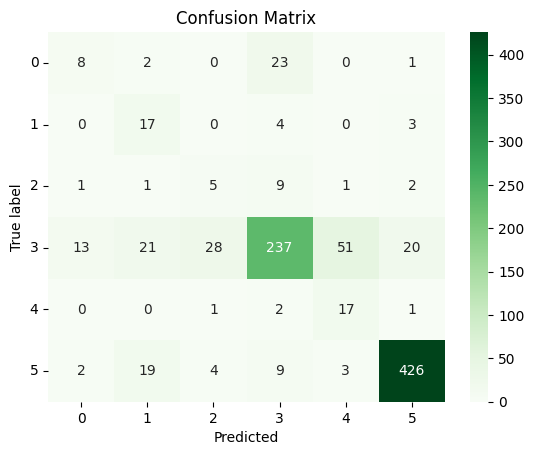

In [ ]:
# confusion matrix
cm= confusion_matrix(df_2_p.part_of,df_2_p.predicted_labels_distilroberta)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Greens, cbar=True)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

In [ ]:
# F1 score
distilroberta__f1_score=f1_score(df_2_p.part_of,df_2_p.predicted_labels_distilroberta, average='micro')
distilroberta__f1_score

0.7626208378088076

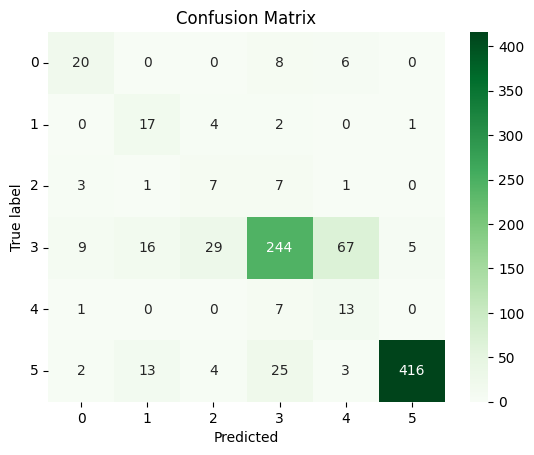

In [ ]:
# confusion matrix
cm= confusion_matrix(df_2_p.part_of,df_2_p.predicted_labels_deberta)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Greens, cbar=True)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

In [ ]:
# F1 score
deberta__f1_score=f1_score(df_2_p.part_of,df_2_p.predicted_labels_deberta, average='micro')
deberta__f1_score

0.7701396348012889

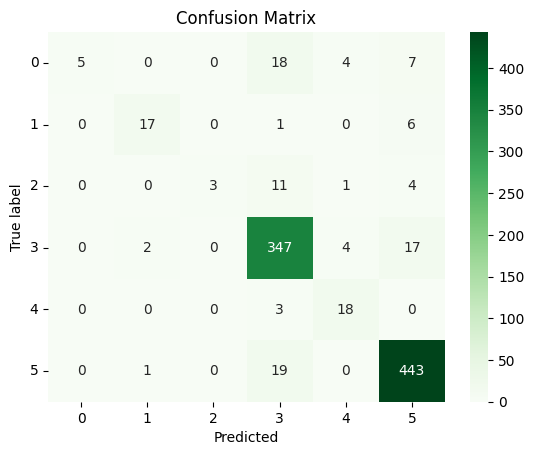

In [ ]:
# confusion matrix
cm= confusion_matrix(df_2_p.part_of,df_2_p.predicted_labels_distilbert)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Greens, cbar=True)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

In [ ]:
# F1 score
distilbert__f1_score=f1_score(df_2_p.part_of,df_2_p.predicted_labels_distilbert, average='micro')
distilbert__f1_score

0.8947368421052632

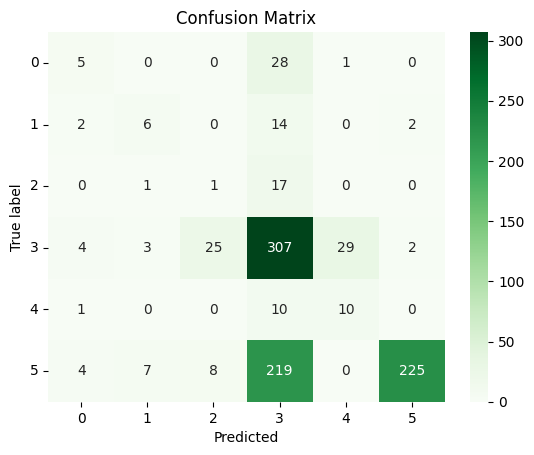

In [ ]:
# confusion matrix
cm= confusion_matrix(df_2_p.part_of,df_2_p.predicted_labels_bart)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Greens, cbar=True)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

In [ ]:
# F1 score
bart__f1_score=f1_score(df_2_p.part_of,df_2_p.predicted_labels_bart, average='micro')
bart__f1_score

0.5950590762620838

In [ ]:
score_2 = {
        'metrics':'f1_score',
        'distillberta': distilroberta__f1_score,
        'deberta': deberta__f1_score,
        'distilbert': distilbert__f1_score,
        'bart': bart__f1_score
    }
score_2
score_data_2 = pd.DataFrame(score_2, index=[0])
score_data_2

,metrics,distillberta,deberta,distilbert,bart
0,f1_score,0.762621,0.77014,0.894737,0.595059
